## Track Comparison: Aurora Prediction vs Observations

Compare Aurora's predicted track with actual observed track from IBTrACS data."

# Track Predictions for Typhoon Nanmadol

In this example, we will download HRES T0 data for 17 Sep 2022 from [WeatherBench2](https://weatherbench2.readthedocs.io/) at 0.25 degrees resolution and use this as an initial condition to predict the track [Typhoon Nanmadol](https://en.wikipedia.org/wiki/Typhoon_Nanmadol_(2022)).

Running this notebook requires additional Python packages. You can install these as follows:

```
pip install gcsfs cdsapi zarr matplotlib
```

## Downloading the Data

To begin with, we download the data from [WeatherBench2](https://weatherbench2.readthedocs.io/).

In [1]:
from pathlib import Path

import fsspec
import xarray as xr

# Data will be downloaded here.
download_path = Path("./data/nanmadol_2022")

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# We will download from Google Cloud.
url = "gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr"
ds = xr.open_zarr(fsspec.get_mapper(url), chunks=None)

# Day to download. This will download all times for that day.
day = "2022-09-17"

# Download the surface-level variables. We write the downloaded data to another file to cache.
if not (download_path / f"{day}-surface-level.nc").exists():
    surface_vars = [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_temperature",
        "mean_sea_level_pressure",
    ]
    ds_surf = ds[surface_vars].sel(time=day).compute()
    ds_surf.to_netcdf(str(download_path / f"{day}-surface-level.nc"))
print("Surface-level variables downloaded!")

# Download the atmospheric variables. We write the downloaded data to another file to cache.
if not (download_path / f"{day}-atmospheric.nc").exists():
    atmos_vars = [
        "temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "specific_humidity",
        "geopotential",
    ]
    ds_atmos = ds[atmos_vars].sel(time=day).compute()
    ds_atmos.to_netcdf(str(download_path / f"{day}-atmospheric.nc"))
print("Atmos-level variables downloaded!")

Surface-level variables downloaded!
Atmos-level variables downloaded!


## Downloading Static Variables from ERA5 Data

The static variables are not available in WeatherBench2, so we need to download them from ERA5, just like we did [in the example for ERA5](example_era5.ipynb).
To do so, register an account with the [Climate Data Store](https://cds.climate.copernicus.eu/) and create `$HOME/.cdsapirc` with the following content:

```
url: https://cds.climate.copernicus.eu/api
key: <API key>
```

You can find your API key on your account page.

In order to be able to download ERA5 data, you need to accept the terms of use in the [dataset page](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download).

In [2]:
from pathlib import Path

import cdsapi

c = cdsapi.Client()

# Download the static variables.
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

Static variables downloaded!


## Preparing a Batch

We convert the downloaded data to an `aurora.Batch`, which is what the model requires.

In [3]:
import numpy as np
import torch
import xarray as xr

from aurora import Batch, Metadata

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / f"{day}-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / f"{day}-atmospheric.nc", engine="netcdf4")


def _prepare(x: np.ndarray) -> torch.Tensor:
    """Prepare a variable.

    This does the following things:
    * Select time points two and three: hours 06:00 and 12:00.
    * Insert an empty batch dimension with `[None]`.
    * Flip along the latitude axis to ensure that the latitudes are decreasing.
    * Copy the data, because the data must be contiguous when converting to PyTorch.
    * Convert to PyTorch.
    """
    return torch.from_numpy(x[[1, 2]][None][..., ::-1, :].copy())


batch = Batch(
    surf_vars={
        "2t": _prepare(surf_vars_ds["2m_temperature"].values),
        "10u": _prepare(surf_vars_ds["10m_u_component_of_wind"].values),
        "10v": _prepare(surf_vars_ds["10m_v_component_of_wind"].values),
        "msl": _prepare(surf_vars_ds["mean_sea_level_pressure"].values),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time. They
        # don't need to be flipped along the latitude dimension, because they are from
        # ERA5.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": _prepare(atmos_vars_ds["temperature"].values),
        "u": _prepare(atmos_vars_ds["u_component_of_wind"].values),
        "v": _prepare(atmos_vars_ds["v_component_of_wind"].values),
        "q": _prepare(atmos_vars_ds["specific_humidity"].values),
        "z": _prepare(atmos_vars_ds["geopotential"].values),
    },
    metadata=Metadata(
        # Flip the latitudes! We need to copy because converting to PyTorch, because the
        # data must be contiguous.
        lat=torch.from_numpy(surf_vars_ds.latitude.values[::-1].copy()),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element. Select the third time point.
        time=(surf_vars_ds.time.values.astype("datetime64[s]").tolist()[2],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.level.values),
    ),
)

## Loading and Running the Model

Finally, we are ready to load and run the model and visualise the predictions. We perform a roll-out for eight steps, which produces predictions for up to two days into the future.

The model can be run locally, or [run on Azure AI Foundry](./foundry/intro.md). To run on Foundry, the environment variables `FOUNDRY_ENDPOINT`, `FOUNDRY_TOKEN`, and `BLOB_URL_WITH_SAS` need to be set. If you're unsure on how to set environment variables, see [here](./foundry/intro.md#accessing-environment-variables-in-a-jupyter-notebook).

In [4]:
from datetime import datetime

from aurora import Tracker

# Initialise the tracker with the position of Nanmadol at 17 Sept 2022 at UTC 12. Taken from
# IBTrACS: https://ncics.org/ibtracs/index.php?name=v04r01-2022254N24143
tracker = Tracker(init_lat=27.50, init_lon=132, init_time=datetime(2022, 9, 17, 12, 0))

# Set to `False` to run locally and to `True` to run on Foundry.
run_on_foundry = False

In [5]:
if not run_on_foundry:
    from aurora import Aurora, Tracker, rollout

    model = Aurora()
    model.load_checkpoint("microsoft/aurora", "aurora-0.25-finetuned.ckpt")

    model.eval()
    model = model.to("cuda")

    preds = []
    with torch.inference_mode():
        for pred in rollout(model, batch, steps=8):
            pred = pred.to("cpu")  # Immediately free up the GPU.
            preds.append(pred)
            tracker.step(pred)

    model = model.to("cpu")

In [6]:
if run_on_foundry:
    import logging
    import os
    import warnings

    from aurora.foundry import BlobStorageChannel, FoundryClient, submit

    # In this demo, we silence all warnings.
    warnings.filterwarnings("ignore")

    # But we do want to show what's happening under the hood!
    logging.basicConfig(level=logging.WARNING, format="%(asctime)s [%(levelname)s] %(message)s")
    logging.getLogger("aurora").setLevel(logging.INFO)

    foundry_client = FoundryClient(
        endpoint=os.environ["FOUNDRY_ENDPOINT"],
        token=os.environ["FOUNDRY_TOKEN"],
    )
    channel = BlobStorageChannel(os.environ["BLOB_URL_WITH_SAS"])

    for pred in submit(
        batch,
        model_name="aurora-0.25-finetuned",
        num_steps=8,
        foundry_client=foundry_client,
        channel=channel,
    ):
        preds.append(pred)
        tracker.step(pred)

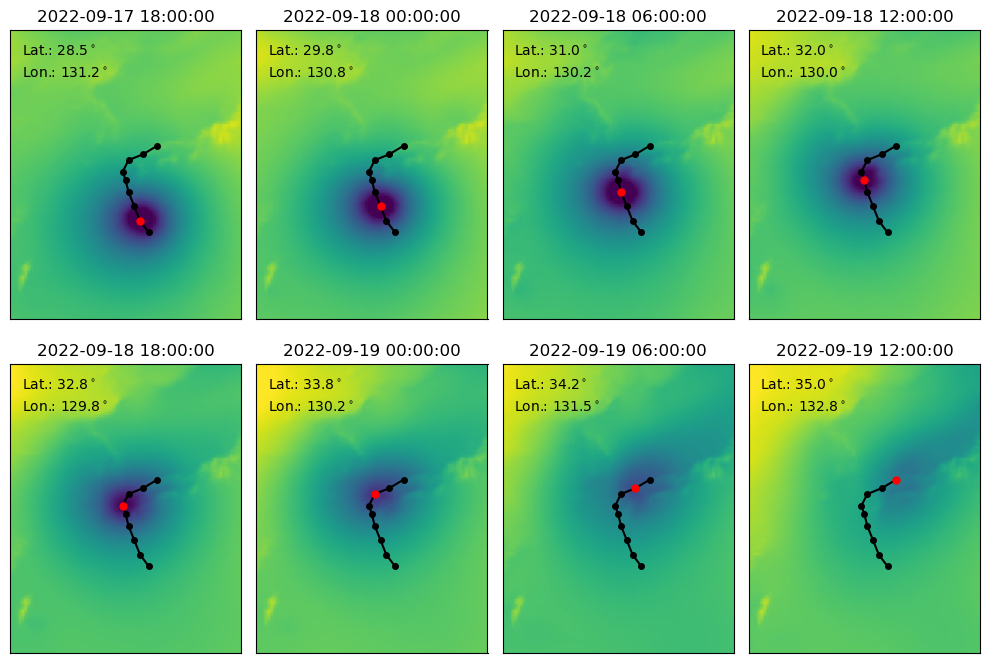

In [7]:
import matplotlib.pyplot as plt

track = tracker.results()

fig, axs = plt.subplots(2, 4, figsize=(10, 7))

for i in range(8):
    pred = preds[i]
    ax = axs[i // 4, i % 4]

    # Cut a square around Nanmadol.
    lat_mask = (pred.metadata.lat >= 20) & (pred.metadata.lat <= 45)
    lon_mask = (pred.metadata.lon >= 120) & (pred.metadata.lon <= 140)

    # Show the forecast for MSL.
    ax.imshow(
        pred.surf_vars["msl"][0, 0][lat_mask][:, lon_mask].numpy() / 100,
        vmin=970,
        vmax=1020,
        extent=(120, 140, 20, 45),
    )
    ax.set_title(str(pred.metadata.time[0]))
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot the whole track for Typhoon Nanmadol.
    ax.plot(track.lon, track.lat, c="k", marker=".", markersize=8)

    # Highlight the current step and also display it on the top left.
    this_step = track[track.time == pred.metadata.time[0]]
    ax.plot(this_step.lon, this_step.lat, c="r", marker=".", markersize=10)
    ax.text(
        0.05,
        0.95,
        f"Lat.: {this_step.lat.iloc[0]:.1f}${{}}^\\circ$",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )
    ax.text(
        0.05,
        0.875,
        f"Lon.: {this_step.lon.iloc[0]:.1f}${{}}^\\circ$",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )

plt.tight_layout()

# Compare with Observation Track

In [9]:
import pandas as pd
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Observational data for Typhoon Nanmadol from IBTrACS
obs_data = [
    ("2022-09-17 12:00", 27.6, 132.0),  # Aurora initialization point
    ("2022-09-17 18:00", 28.5, 131.4),
    ("2022-09-18 00:00", 29.7, 131.0),
    ("2022-09-18 06:00", 30.7, 130.7),
    ("2022-09-18 12:00", 31.9, 130.6),
    ("2022-09-18 18:00", 33.1, 130.5),
    ("2022-09-19 00:00", 34.1, 131.1),
    ("2022-09-19 06:00", 34.8, 132.4),
    ("2022-09-19 12:00", 36.1, 134.3)
]

# Convert to DataFrame
obs_df = pd.DataFrame(obs_data, columns=['datetime', 'lat', 'lon'])
obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])

# Filter observations to match prediction period (Sep 17 12:00 to Sep 19 12:00)
init_time = datetime(2022, 9, 17, 12, 0)
end_time = init_time + timedelta(hours=48)

# Get observed track during prediction period
obs_forecast_period = obs_df[
    (obs_df['datetime'] >= init_time) & 
    (obs_df['datetime'] <= end_time)
].copy()

# Get predicted track data
pred_track = tracker.results()

/home/qhuang62/.local/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


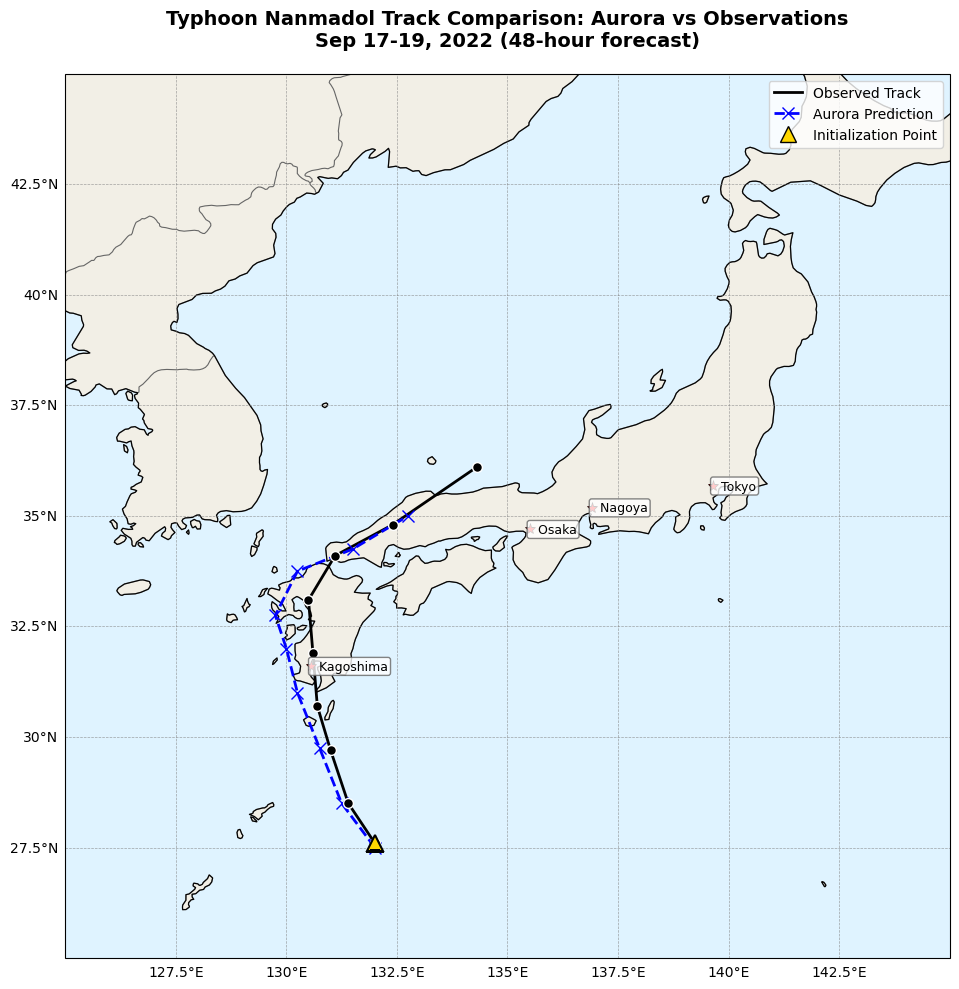


Track Comparison Summary:
Forecast period: 2022-09-17 12:00:00 to 2022-09-19 12:00:00
Number of predicted points: 9
Number of observed points: 9

Final position comparison:
Observed final position: 36.1°N, 134.3°E
Predicted final position: 35.0°N, 132.8°E
Position error: 1.1° lat, 1.6° lon


In [11]:
# Create track comparison visualization
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent to focus on typhoon region
ax.set_extent([125, 145, 25, 45], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.OCEAN, facecolor='#dff3ff')
ax.add_feature(cfeature.LAND, facecolor='#f2efe6', edgecolor='0.5')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.8, color="0.4")
ax.coastlines('50m', linewidth=0.8)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='0.5', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot observed track (black line with circles)
ax.plot(obs_forecast_period.lon, obs_forecast_period.lat, 'k-', linewidth=2, 
        transform=ccrs.PlateCarree(), label='Observed Track')
ax.scatter(obs_forecast_period.lon, obs_forecast_period.lat, c='black', s=50, 
          edgecolors='white', linewidth=1, transform=ccrs.PlateCarree(), zorder=5)

# Plot predicted track (blue line with x markers)
ax.plot(pred_track.lon, pred_track.lat, 'b--', linewidth=2, marker='x', markersize=8,
        transform=ccrs.PlateCarree(), label='Aurora Prediction')

# Mark initialization point
init_lon, init_lat = 132.0, 27.6
ax.plot(init_lon, init_lat, '^', markersize=12, color='gold', markeredgecolor='black', 
        markeredgewidth=1.5, transform=ccrs.PlateCarree(), zorder=6, 
        label='Initialization Point')

# Add nearby cities
cities = [
    ("Tokyo", 35.6762, 139.6503),
    ("Osaka", 34.6937, 135.5023),
    ("Nagoya", 35.1815, 136.9066),
    ("Kagoshima", 31.5966, 130.5571),
]

for name, lat, lon in cities:
    ax.plot(lon, lat, marker='*', markersize=8, color='red', 
            markeredgecolor='black', markeredgewidth=0.5,
            transform=ccrs.PlateCarree(), zorder=6)
    ax.text(lon, lat, f'  {name}', transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                     edgecolor='0.4', alpha=0.8), zorder=6)

# Add legend
legend_handles = [
    Line2D([0], [0], color='black', linewidth=2, label='Observed Track'),
    Line2D([0], [0], color='blue', linewidth=2, linestyle='--', 
           marker='x', markersize=8, label='Aurora Prediction'),
    Line2D([0], [0], marker='^', markersize=12, color='gold', 
           markeredgecolor='black', linewidth=0, label='Initialization Point')
]
ax.legend(handles=legend_handles, loc='upper right', fontsize=10, frameon=True)

# Set title
ax.set_title('Typhoon Nanmadol Track Comparison: Aurora vs Observations\n'
             'Sep 17-19, 2022 (48-hour forecast)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Calculate simple track error metrics
if len(pred_track) > 0 and len(obs_forecast_period) > 0:
    print("\nTrack Comparison Summary:")
    print(f"Forecast period: {init_time} to {end_time}")
    print(f"Number of predicted points: {len(pred_track)}")
    print(f"Number of observed points: {len(obs_forecast_period)}")
    
    # Calculate final position error
    final_obs = obs_forecast_period.iloc[-1]
    final_pred = pred_track.iloc[-1]
    
    lat_error = abs(final_pred.lat - final_obs.lat)
    lon_error = abs(final_pred.lon - final_obs.lon)
    
    print(f"\nFinal position comparison:")
    print(f"Observed final position: {final_obs.lat:.1f}°N, {final_obs.lon:.1f}°E")
    print(f"Predicted final position: {final_pred.lat:.1f}°N, {final_pred.lon:.1f}°E")
    print(f"Position error: {lat_error:.1f}° lat, {lon_error:.1f}° lon")